# Example1: Basic RevelsMD Functionality RDF

Welcome to revelsMD a one stop shot for reduced variance sampling using various techiniques based around the usage of force densities.

In [1]:
from revelsmd.trajectory_states import LammpsTrajectoryState
from revelsmd.revels_rdf import RevelsRDF
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as md
%matplotlib inline

First we generate a trajectory state, the trajectory state is a python project which defines the necessary information about a trajectory required for parsing. RevelsMD can operate on a number of different trajecotry types flexing across core MD codes (lammps and gromacs), aimd dft codes (vasp), and a slightly more involved numpy driven version. In order to be able to parse forces and positions from each of these codes different parsers are used for each software and the TrajectoryState allows this to be flexibly under the hood.

In [2]:
traj=LammpsTrajectoryState('examples/example_1_LJ/dump.nh.lammps','examples/example_1_LJ/data.fin.nh.data',units='lj',atom_style="id resid type q x y z ix iy iz")

Then we feed it to a run function if your using lammps data as in this case you will need to assert if you are using lj, real, or metal units.

## Calculating an rdf from infinity 

We can then run a radial distribution function using RevelsMD. As described here (https://aip.scitation.org/doi/abs/10.1063/5.0053737) we have the ability to caluclate three different ways, by taking our Heaviside function from: infinity to zero, zero to inifity, or performing a linear combination of the two. Here we start by using the oldest formulation (from inifity) developed by Borgis.

In [3]:
RDF=RevelsRDF.run_rdf(traj,'1','1',1.35,period=1,delr=0.005,from_zero=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [05:02<00:00,  6.17s/it]


In [4]:
help(RevelsRDF.run_rdf)

Help on function run_rdf in module revelsmd.revels_rdf:

run_rdf(TS, atom_a, atom_b, temp, delr=0.01, start=0, stop=-1, period=1, rmax=True, from_zero=True)
    This is the master function for running a force RDF.
    
    args:
    TS (A RevelsMD trajectory state object): An object obtaining all of the trajectory paramaters
    atom_a (string): The type of the first atom for which the rdf will be calculated
    atom_b (string): The type of the second atom for which the rdf will be calculated, if atom_a == atom_b a like pairs rdf is automatically calculated
    temp (float): Temperature of the system
    delr (float): The spacing between radial points in an RDF (this is not a bin width as this is not a histogram but a heaviside)
    kwargs:
    start (int): The first frame for which the radial distribution function will be calculated
    stop (int): The last value for which the radial distribution function will be calculated
    period (int): The jumps made between sampled frames
    r

Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

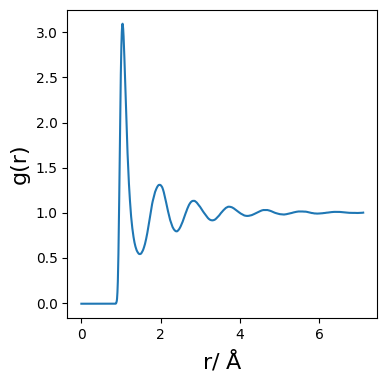

In [5]:
plt.figure(figsize=(4,4))
plt.plot(RDF[0,:],RDF[1,:])
plt.ylabel('g(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)

One of the adventages of this family of methods is that a continuous if often noisy instantaneous (single frame) radial distribution function can be calculated. We can obtain this by setting the period to the number of frames in the the trajectory state.

In [ ]:
RDF_instaneous=RevelsRDF.run_rdf(traj,'1','1',1.35,period=int(traj.frames),delr=0.005,from_zero=False)

  0%|                                                                                              | 0/1 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(RDF[0,:],RDF[1,:])
plt.plot(RDF_instaneous[0,:],RDF_instaneous[1,:],color='red',linestyle='dashed')
plt.ylabel('g(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)

Here this is exceptional agreement, for systems with less particles or where the system is solvate, it will be much worse, but it is important to remember that even if the graph is visulaly unappealing an instantaneous calculation has utility for the calculation of instantaneous thermodynmaic quantatities.

## Calculating an rdf from zero 

In comparison to conventional methodolgies force integration will not always recover directly both the zero and infinite limits, there is therefore a choice of whether to obtain a small (often inperceptable) error in the zero or large r limit. We chose to obtain the zero limit correctly with g(r)=0 as the default, this is as an infinite limit of 1 is not strictly always required, nor as aphysical as allowing overlap of particles up to r=0. 

From the perspective of the code this means that if from_zero is not set to false the calculation will be performed with Heaviside function taken from zero.

In [12]:
RDF_default=RevelsRDF.run_rdf(traj,'1','1',1.35,period=1,delr=0.005)

100%|████████████████████████████████████████████████████████████████████████████████████| 49/49 [05:14<00:00,  6.42s/it]


Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

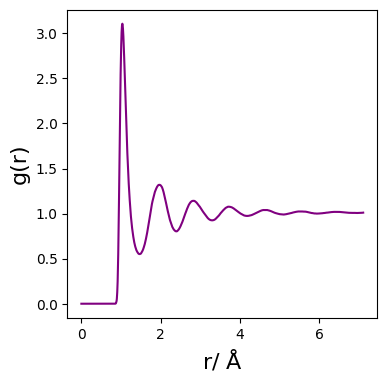

In [10]:
plt.figure(figsize=(4,4))
plt.plot(RDF_default[0,:],RDF_default[1,:],color='purple')
plt.ylabel('g(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)

## Using a linear combination of these terms

The linear combination method described in https://aip.scitation.org/doi/abs/10.1063/5.0053737 has a way of removing the issue of incorrect limits, by taking a linear combination. This can be obtained by using run_rdf_lambda, which has the same inputs as the conventional rdf calculation.

In [11]:
RDF_lambda=RevelsMDRDF.run_rdf_lambda(traj,'1','1',1.35,period=1,delr=0.005)

100%|███████████████████████████████████████████| 49/49 [05:21<00:00,  6.56s/it]


The output of this function is a (number of bins) x 3 array with the bins as the first collumn, the refined g(r) values in the middle collumn and the linear combination described in the paper as the third collumn. 

The rdf is indistinguishable for the number o particles in this example. But the limits are now correct.

Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

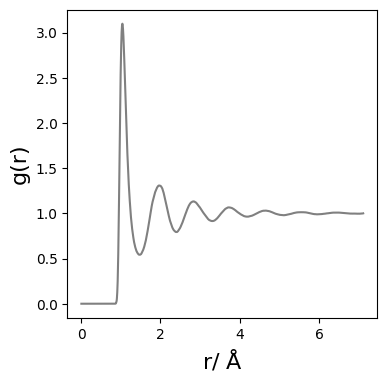

In [12]:
plt.figure(figsize=(4,4))
plt.plot(RDF_lambda[:,0],RDF_lambda[:,1],color='grey')
plt.ylabel('g(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)

The linear combination giving that rdf is shown below, the form will vary between systems, it'll always be 1 at r=0, and zero at r=infinity. As a general rule, the value will normaly be close to 0 at intermediate values to, as the first peak will have the greatest affect on varience.

Text(0.5, 0, 'r/ $\\operatorname{\\AA}$')

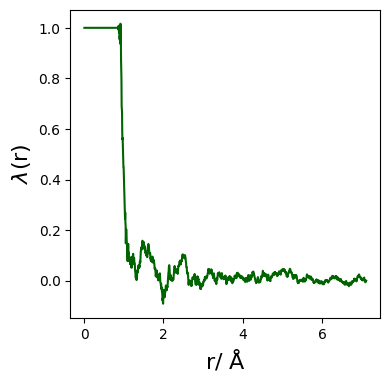

In [13]:
plt.figure(figsize=(4,4))
plt.plot(RDF_lambda[:,0],RDF_lambda[:,2],color='darkGreen')
plt.ylabel(r'$\lambda$(r)',size=16)
plt.xlabel(r'r/ $\operatorname{\AA}$',size=16)